# ECOS 데이터 받기

- 작성자: 고려대학교 경제학과 한치록 교수
- 본 매뉴얼은 로컬환경에서 활용하는 것을 목적으로 작성

[한국은행 경제통계 Open API 서비스](https://ecos.bok.or.kr/api/)를 이용하여 데이터를 읽는 방법에 대하여 설명한다. OPEN API 인증키는 이미 가지고 있다고 가정한다.

다음에 특정 통계항목을 특정 기간 동안 ECOS API를 활용하여 받아 pandas DataFrame으로 저장하는 절차를 설명하고, 마지막에 [ecosapi.py 모듈][ecosmod]에 대해 설명한다. 중간 단계에 관심이 없는 독자는 곧바로 [ecosapi.py][ecosmod] 부분으로 넘어가도 좋다.

## 수동 검색 및 내려받기

ECOS 데이터를 받는 것는 다음 3가지 단계로 이루어진다.

1. 통계표 코드 검색
2. 해당 통계표의 통계항목 검색
3. 1단계 통계표 코드와 2단계 통계항목 코드를 이용하여 데이터 다운로드

이하에서는 이 3가지 절차에 대하여 설명하고, 마지막으로 [ecosapi.py][ecosmod] 모듈을 설명한다.

### ECOS 통계표 코드 검색 예시

통계표 코드를 검색하는 방법을 설명한다. 통계표 코드는 [ECOS 통계검색 페이지][ecosweb]에서 직접 확인할 수도 있고, [ECOS 통계검색 페이지][ecosweb]의 '전체다운로드' 버튼을 이용하여 엑셀을 내려받아 직접 열어 검색해도 좋다. 2024. 1. 4.에 내려받은 코드표를 `ECOS-Tables.xlsx` 파일로 저장해 두었다. 이 파일을 파이썬으로 검색하는 것도 가능하다. 이 소절에서는 이에 대해 설명한다. `ECOS-Tables.xlsx` 파일은 사람 눈에는 보기 좋게 되어 있으나 컴퓨터로 처리하기에는 복잡하다. 내려받은 파일 내용은 다음과 같다.

[ecosweb]: https://ecos.bok.or.kr/#/SearchStat
[ecosmod]: #ecos_module

In [1]:
import pandas as pd
import numpy as np

tbl = pd.read_excel('data/ECOS-Tables.xlsx')
tbl

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,"분류,통계표명","분류,통계표 ID"
0,1. 통화/금융,NaN,NaN,NaN,NaN,NaN,0000000001
1,NaN,1.1. 통화/유동성,NaN,NaN,NaN,NaN,0000000002
2,NaN,NaN,1.1.1. 본원통화,NaN,NaN,NaN,0000000003
3,NaN,NaN,NaN,1.1.1.1. 본원통화 구성내역,NaN,NaN,0000000004
4,NaN,NaN,NaN,NaN,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",NaN,102Y004
...,...,...,...,...,...,...,...
836,NaN,NaN,NaN,9.2.1.2. 한국/북한 배율,NaN,NaN,251Y002
837,NaN,NaN,9.2.2. 북한의 경제활동별 국내총생산,NaN,NaN,NaN,251Y001
838,NaN,NaN,9.2.3. 북한의 시장물가와 환율,NaN,NaN,NaN,0000000704
839,NaN,NaN,NaN,9.2.3.1. 시장물가지수,NaN,NaN,252Y001


이름들이 수준에 따라 흩어져 있고 `NaN`이 많아서 먼저 검색이 간편하도록 정리해 주어야 한다. 검색을 위해서는 칼럼 0\~4 (`Unnamed: 0`\~`Unnamed: 4`)의 `NaN` (`np.nan`)을 적절한 방식으로 채운다. 다음 코드가 이를 실행한다. 실행 결과는 아래에 있다.

In [2]:
# https://stackoverflow.com/questions/27905295/how-to-replace-nans-by-preceding-or-next-values-in-pandas-dataframe

# Forward fill NA
def fill_na(lvl, sublvl):
    is_lvl_na = pd.isna(lvl) #[pd.isna(i) for i in lvl]
    ans = lvl.ffill()
    ans[is_lvl_na & pd.isna(sublvl)] = np.nan
    #ans = [(np.nan if x and pd.isna(z) else y) for x,y,z in zip(is_lvl_na,ans,sublvl)] # inefficient?
    return ans

names = tbl.columns.tolist()
for i in reversed(range(5)):
    tbl[names[i]] = fill_na(tbl[names[i]], tbl[names[i+1]])

# Replace NA with ''
# https://stackoverflow.com/questions/26837998/pandas-replace-nan-with-blank-empty-string
tbl = tbl.replace(np.nan, '', regex = True)

# Rename columns
names[:6] = [f'Cat{i+1}' for i in range(6)]
names[6] = 'ID'
tbl.columns = names
tbl

,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,ID
0,1. 통화/금융,,,,,,0000000001
1,1. 통화/금융,1.1. 통화/유동성,,,,,0000000002
2,1. 통화/금융,1.1. 통화/유동성,1.1.1. 본원통화,,,,0000000003
3,1. 통화/금융,1.1. 통화/유동성,1.1.1. 본원통화,1.1.1.1. 본원통화 구성내역,,,0000000004
4,1. 통화/금융,1.1. 통화/유동성,1.1.1. 본원통화,1.1.1.1. 본원통화 구성내역,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",,102Y004
...,...,...,...,...,...,...,...
836,9. 해외/북한,9.2. 북한 관련 통계,9.2.1. 남북한 주요지표 비교,9.2.1.2. 한국/북한 배율,,,251Y002
837,9. 해외/북한,9.2. 북한 관련 통계,9.2.2. 북한의 경제활동별 국내총생산,,,,251Y001
838,9. 해외/북한,9.2. 북한 관련 통계,9.2.3. 북한의 시장물가와 환율,,,,0000000704
839,9. 해외/북한,9.2. 북한 관련 통계,9.2.3. 북한의 시장물가와 환율,9.2.3.1. 시장물가지수,,,252Y001


위 통계표 정보 테이블을 검색하자. Cat1\~Cat6 칼럼을 모두 검색한다. 검색 대상이 되는 칼럼명을 자동으로 추출하면 다음과 같다.

In [3]:
cols = [x for x in tbl.columns if x.startswith('Cat')]
cols

['Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6']

검색은 [pandas.DataFrame.query](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html)를 사용하면 될 것이다. 예를 들어 `Cat4` 칼럼에서 '대미달러'를 검색하려면 다음과 같이 한다.

In [4]:
tbl.query("Cat4.str.contains('대미달러')")

,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,ID
433,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.1. 일일환율,3.1.1.2. 주요국 통화의 대미달러환율,,,731Y002
434,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.1. 일일환율,"3.1.1.3. 원화의 대미달러, 원화의 대위안/대엔 환율",,,731Y003
437,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.2. 평균환율/기말환율,3.1.2.2. 주요국 통화의 대미달러환율,,,731Y005
438,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.2. 평균환율/기말환율,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",,,731Y006


이제 위의 `cols` 칼럼들에 대해서 "대미달러.*환율" 정규표현식이 포함된 통계표들을 검색해 보자.

In [5]:
import re

pattern = '대미달러.*환율' # regex

res = pd.DataFrame(index = tbl.index, dtype = 'bool') # empty dataframe
for col in cols: res[col] = [bool(re.search(pattern, x)) for x in tbl[col]]

# 검색 결과
tbl[res.any(axis=1)]  # any, all, ans[:,0], etc.

,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,ID
433,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.1. 일일환율,3.1.1.2. 주요국 통화의 대미달러환율,,,731Y002
434,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.1. 일일환율,"3.1.1.3. 원화의 대미달러, 원화의 대위안/대엔 환율",,,731Y003
437,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.2. 평균환율/기말환율,3.1.2.2. 주요국 통화의 대미달러환율,,,731Y005
438,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.2. 평균환율/기말환율,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",,,731Y006


`Cat1`\~`Cat6` 칼럼들 중 하나라도 `pattern` 정규식을 포함하는 통계표가 위에 있다. 더 복잡한 검색은 [pandas.DataFrame.query](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html)를 사용하면 될 것이다. 예를 들어
```python
tbl.query("Cat4.str.contains('대미달러')")
```

### 통계항목 검색 예시

이제 본격적으로 데이터를 가져오자. 여기에는 API key가 필요하다. 이후의 설명은 `BIDAS 환경`이 아닌 `로컬환경(내부망, 외부망의 pc 환경)`에서 활용하는 것을 목적으로 작성한 것이다. 아래 ecos_key에 자신의 계정의 API key를 입력한다.

In [6]:
ecos_key = '-------------------' # Replace with your own personal key

예시 대상은 '3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율'이다(위 인덱스 438). 통계표 ID는 "731Y006"이다. 이 통계표에 포함되어 있는 '통계항목'들을 살펴보아야 한다. 먼저 ECOS api를 이용하여 ID가 "731Y006"인 통계표의 통계항목 리스트를 내려받자.

In [7]:
import requests, json
import pandas as pd

ecos_api = 'http://ecos.bok.or.kr/api' # IMPORTANT: 'https' might not work (SSL HANDSHAKE ERROR)
stat_code = '731Y006' # 3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율

svc_name = 'StatisticItemList'
format = 'json'
lang_type = 'kr'
start_no = 1
end_no = 100000

def hide_key(text, key = ecos_key): return text.replace(key, '***')+' (key hidden)' # hide personal key
#def hide_key(text): return text # for debugging

# See ECOS api manual for how to compose the url
url = '/'.join([ecos_api, svc_name, ecos_key, format, lang_type, f'{start_no}', f'{end_no}', stat_code])
print(hide_key(url))
response = requests.get(url)

http://ecos.bok.or.kr/api/StatisticItemList/***/json/kr/1/100000/731Y006 (key hidden)


위에서 ECOS api로부터 내려받은 통계항목 정보는 `response`에 있다. 이제 이 정보를 처리한다.

In [8]:
json = response.json()[svc_name]
count = json['list_total_count'] # unnecessary
items = pd.DataFrame(json['row'])
print(items.shape)
print(items.columns.tolist())
cols_to_disp = ['GRP_CODE', 'GRP_NAME', 'ITEM_CODE', 'ITEM_NAME', 'CYCLE', 'DATA_CNT', 'UNIT_NAME', 'START_TIME', 'END_TIME']
items[cols_to_disp]

(44, 14)
['STAT_CODE', 'STAT_NAME', 'GRP_CODE', 'GRP_NAME', 'ITEM_CODE', 'ITEM_NAME', 'P_ITEM_CODE', 'P_ITEM_NAME', 'CYCLE', 'START_TIME', 'END_TIME', 'DATA_CNT', 'UNIT_NAME', 'WEIGHT']


,GRP_CODE,GRP_NAME,ITEM_CODE,ITEM_NAME,CYCLE,DATA_CNT,UNIT_NAME,START_TIME,END_TIME
0,Group1,계정항목,0000002,원/달러(시가),A,40,원,2004,2023
1,Group1,계정항목,0000002,원/달러(시가),M,486,원,200403,202405
2,Group1,계정항목,0000002,원/달러(시가),Q,162,원,2004Q1,2024Q1
3,Group1,계정항목,0000002,원/달러(시가),S,80,원,2004S1,2023S2
4,Group1,계정항목,0000005,원/달러(고가),A,40,원,2004,2023
5,Group1,계정항목,0000005,원/달러(고가),M,486,원,200403,202405
6,Group1,계정항목,0000005,원/달러(고가),Q,162,원,2004Q1,2024Q1
7,Group1,계정항목,0000005,원/달러(고가),S,80,원,2004S1,2023S2
8,Group1,계정항목,0000004,원/달러(저가),A,40,원,2004,2023
9,Group1,계정항목,0000004,원/달러(저가),M,486,원,200403,202405


Group1과 Group2가 섞여 있다. Group1은 총 36개, Group2는 총 8개로서 총 44개이다. Group1은 계정항목, Group2는 측정항목이다. Group1는 원/달러(시가) 등을 포함하며, Group2는 평균자료와 말일자료로 구분된다. [ECOS 웹 인터페이스](https://ecos.bok.or.kr/#/SearchStat)와 비교하면 무슨 뜻인지 이해할 수 있다. 이하에서는 분기별 원/달러(종가) 평균자료를 내려받고자 한다.

### 데이터 내려받기 예시

[한국은행 Open API 서비스 개발가이드](https://ecos.bok.or.kr/api/#/DevGuide/DevSpeciflcation) 개발명세서의 '통계 조회 조건 설정' 참조. 필요한 것은 순서대로 다음과 같고 URL에 `/`로 구분하여 연결한다.

> 서비스명(StatisticResearch), 인증키, 요청유형(json 또는 xml), 언어구분(kr), 요청시작건수, 요청종료건수, 통계표코드(STAT_CODE), 주기(CYCLE), 검색시작일자, 검색종료일자, 통계항목코드1(ITEM_CODE), 통계항목코드2(ITEM_CODE), 통계항목코드3(ITEM_CODE), 통계항목코드4(ITEM_CODE)

마지막 통계항목코드1~4는 옵셔널이다. 우리의 예에서는 Group1과 Group2가 있으므로 통계항목코드1과 통계항목코드2가 필요하다. 아래에서 두 통계항목코드는 각각 `item1`과 `item2`이다.

In [9]:
svc_name = 'StatisticSearch'
cycle = 'Q'
item1 = '0000003'
item2 = '0000100'
start_date = '2011Q1'
end_date = '2012Q4'

다음으로 전체 관측치 수를 알아내자. 전체 관측치 수를 알아낼 때에는 실제 데이터를 모두 가져올 필요가 없으므로 1개만 다운로드한다. 이를 위해 '요청시작건수'와 '요청종료건수'를 모두 1로 설정한다.

In [10]:
start_no = 1
end_no = 1
url = '/'.join([ecos_api, svc_name, ecos_key, format, lang_type, f'{start_no}', f'{end_no}', stat_code, cycle, 
                start_date, end_date, item1, item2])
print(hide_key(url))
response = requests.get(url)
response

http://ecos.bok.or.kr/api/StatisticSearch/***/json/kr/1/1/731Y006/Q/2011Q1/2012Q4/0000003/0000100 (key hidden)


<Response [200]>

다운로드가 완료되었다. 관측치 수는 `list_total_count`에 있다.

In [11]:
json = response.json()[svc_name]
count = json['list_total_count']
count

8

이제 요청종료건수를 `count` 값으로 주고 다시 호출한다.

In [12]:
url = '/'.join([ecos_api, svc_name, ecos_key, format, lang_type, f'{start_no}', f'{count}', stat_code, cycle, 
                start_date, end_date, item1, item2])
response = requests.get(url)

내려받은 결과를 처리한다.

In [13]:
json = response.json()[svc_name]
data = pd.DataFrame(json['row'])
data

,STAT_CODE,STAT_NAME,ITEM_CODE1,ITEM_NAME1,ITEM_CODE2,ITEM_NAME2,ITEM_CODE3,ITEM_NAME3,ITEM_CODE4,ITEM_NAME4,UNIT_NAME,WGT,TIME,DATA_VALUE
0,731Y006,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",0000003,원/달러(종가),0000100,평균자료,None,None,None,None,원,None,2011Q1,1119.82
1,731Y006,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",0000003,원/달러(종가),0000100,평균자료,None,None,None,None,원,None,2011Q2,1083.24
2,731Y006,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",0000003,원/달러(종가),0000100,평균자료,None,None,None,None,원,None,2011Q3,1085.07
3,731Y006,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",0000003,원/달러(종가),0000100,평균자료,None,None,None,None,원,None,2011Q4,1143.99
4,731Y006,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",0000003,원/달러(종가),0000100,평균자료,None,None,None,None,원,None,2012Q1,1131.27
5,731Y006,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",0000003,원/달러(종가),0000100,평균자료,None,None,None,None,원,None,2012Q2,1152.11
6,731Y006,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",0000003,원/달러(종가),0000100,평균자료,None,None,None,None,원,None,2012Q3,1132.97
7,731Y006,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",0000003,원/달러(종가),0000100,평균자료,None,None,None,None,원,None,2012Q4,1090.3


필요한 칼럼은 `TIME`과 `DATA_VALUE`이다. 아래에 이들 정보로부터 DataFrame을 만든다. 하지만 원한다면 단위 등 다른 정보도 얻을 수 있다.

In [14]:
df = data.loc[:, ['TIME', 'DATA_VALUE']]
df.columns = ['time', 'value']
df['value'] = df.value.astype(float) # or pd.to_numeric(df['value'])
df

,time,value
0,2011Q1,1119.82
1,2011Q2,1083.24
2,2011Q3,1085.07
3,2011Q4,1143.99
4,2012Q1,1131.27
5,2012Q2,1152.11
6,2012Q3,1132.97
7,2012Q4,1090.30


그림을 그려 보자. 위에서는 날짜가 `str` 그대로 있다. 이를 날짜로 바꾸고 나서 그림을 그리겠다. (이 데이터 클린업 함수도 `ecosapi.py` 모듈에 제공된다.)

<Axes: xlabel='date'>

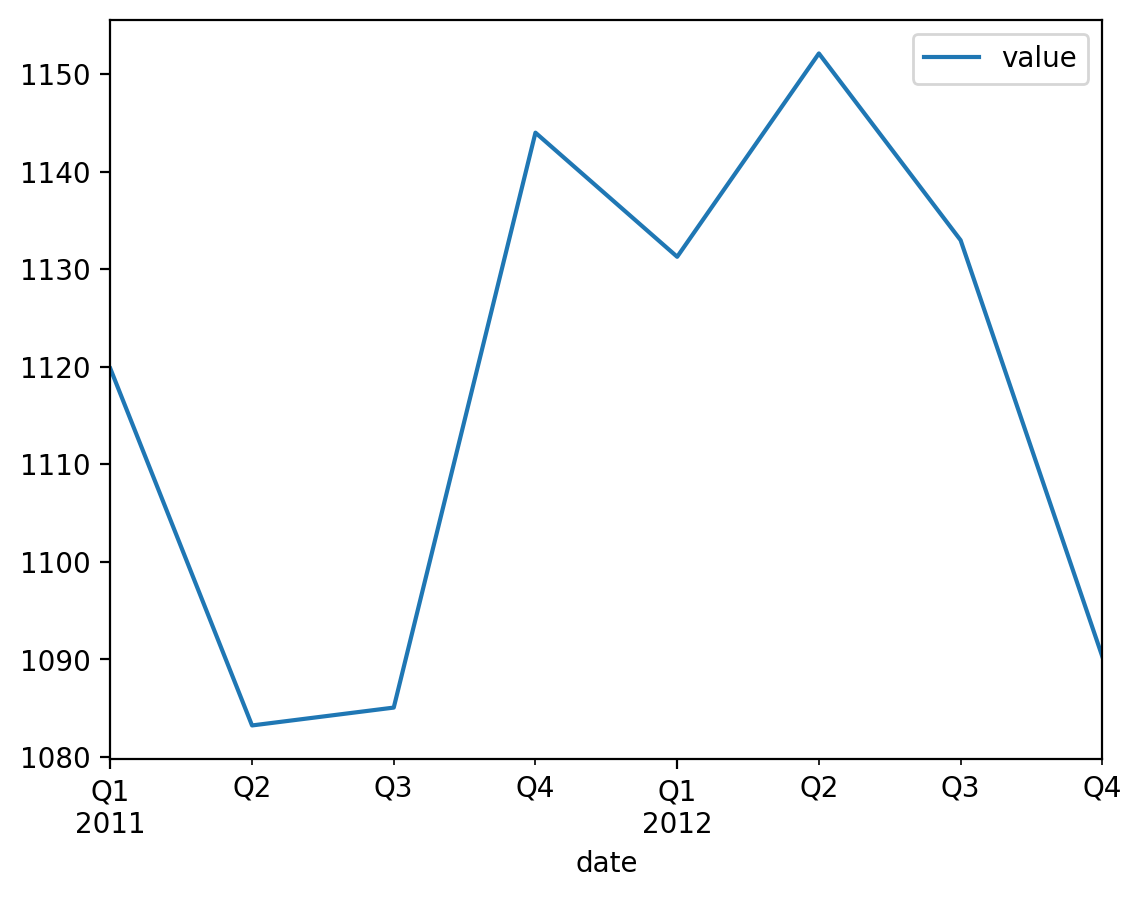

In [15]:
df['date'] = pd.PeriodIndex(df.time,freq='Q').to_timestamp()

# Run the following line if you have a retina (HiDPI) display
%config InlineBackend.figure_format = "retina"
df.plot(x='date', y='value')

이상은 `GRP_CODE`가 "Group1"과 "Group2"로 혼합된 경우여서 복잡했다. `GRP_CODE`가 "Group1"만 있으면 Group2를 고려하지 않아도 되므로 더 간단하다. 이에 대해서는 ECOS API 모듈에서 살펴본다.

<a id="ecos_module"></a>

## ECOS API 모듈

이상의 방법을 `bok_da` 라이브러리 - 데이터 처리 패키지(`data`) 내 `ecosapi.py` 파일에 모듈로 구현하여 두었다.

In [1]:
from bok_da.data import ecosapi
ecos = ecosapi.EcosAPI() # or ecosapi.EcosAPI(ecos_key)

* Rebuild table database from ECOS-Tables.xlsx
* Table database saved as ECOS-Tables.pkl


### 통계표 검색

먼저 통계표를 검색하여 코드를 찾아보자.

In [2]:
ecos.search_tbl('대미달러.*환율') # ecos_key is not required yet

,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,ID
433,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.1. 일일환율,3.1.1.2. 주요국 통화의 대미달러환율,,,731Y002
434,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.1. 일일환율,"3.1.1.3. 원화의 대미달러, 원화의 대위안/대엔 환율",,,731Y003
437,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.2. 평균환율/기말환율,3.1.2.2. 주요국 통화의 대미달러환율,,,731Y005
438,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.2. 평균환율/기말환율,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",,,731Y006


참고로, regular expression을 사용하지 않으려면 `regex=False` 인자를 사용한다.

In [3]:
ecos.search_tbl('평균환율', regex=False) # ecos_key is not required yet

,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,ID
435,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.2. 평균환율/기말환율,,,,0000000182
436,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.2. 평균환율/기말환율,3.1.2.1. 주요국 통화의 대원화환율,,,731Y004
437,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.2. 평균환율/기말환율,3.1.2.2. 주요국 통화의 대미달러환율,,,731Y005
438,3. 환율/통관수출입/외환보유액,3.1. 환율,3.1.2. 평균환율/기말환율,"3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율",,,731Y006


### 통계항목 검색

다음은 코드 "731Y006"에 해당하는 통계항목 리스트를 ECOS로부터 읽는다.

In [19]:
stat_code = '731Y006' # also sets ecos.statcode
ecos.key = ecos_key  # your ECOS api key
# 주어진 통계표의 통계항목 리스트 다운로드
ecos.download_items(stat_code, simplify = True) # Many unnecessary columns without 'simplify = True'
ecos.items

,STAT_CODE,GRP_CODE,GRP_NAME,ITEM_CODE,ITEM_NAME,CYCLE,DATA_CNT,UNIT_NAME,START_TIME,END_TIME
0,731Y006,Group1,계정항목,0000002,원/달러(시가),A,40,원,2004,2023
1,731Y006,Group1,계정항목,0000002,원/달러(시가),M,486,원,200403,202405
2,731Y006,Group1,계정항목,0000002,원/달러(시가),Q,162,원,2004Q1,2024Q1
3,731Y006,Group1,계정항목,0000002,원/달러(시가),S,80,원,2004S1,2023S2
4,731Y006,Group1,계정항목,0000005,원/달러(고가),A,40,원,2004,2023
5,731Y006,Group1,계정항목,0000005,원/달러(고가),M,486,원,200403,202405
6,731Y006,Group1,계정항목,0000005,원/달러(고가),Q,162,원,2004Q1,2024Q1
7,731Y006,Group1,계정항목,0000005,원/달러(고가),S,80,원,2004S1,2023S2
8,731Y006,Group1,계정항목,0000004,원/달러(저가),A,40,원,2004,2023
9,731Y006,Group1,계정항목,0000004,원/달러(저가),M,486,원,200403,202405


중요한 것은 `GRP_CODE`에 무엇이 있는지 확인하는 것이다. 위 표를 눈으로 훑어봐도 되지만 unique한 값들이 무엇인지 대략적으로 살펴보자.

In [20]:
ecos.items.GRP_CODE.unique().tolist()

['Group1', 'Group2']

In [21]:
ecos.items.GRP_NAME.unique().tolist()

['계정항목', '측정항목']

In [22]:
print(ecos.items.ITEM_NAME.unique().tolist())

['원/달러(시가)', '원/달러(고가)', '원/달러(저가)', '원/달러(종가)', '원/위안(시가)', '원/위안(고가)', '원/위안(저가)', '원/위안(종가)', '원/100엔(하나은행고시)', '평균자료', '말일자료']


위 예에서는 Group1 (계정항목)과 Group2 (측정항목)가 있다. 계정항목(Group1)은 '원/달러(시가)' 등이고, 측정항목(Group2)은 '평균자료', '말일자료'이다. 실제 ECOS 웹 인터페이스로부터도 이를 확인할 수 있다.

편의를 위하여 다운로드된 통계항목 데이터프레임의 `ITEM_NAME` 칼럼을 검색하는 함수를 `ecosapi.EcosAPI.search_item`으로 구현하였다. 검색 결과로부터 필요한 칼럼들을 표시하면 다음과 같다.

In [23]:
#import importlib
#importlib.reload(ecosapi)
#ecos = ecosapi.EcosAPI(ecos_key)
#ecos.download_items(stat_code, simplify = True) # Many unnecessary columns without 'simplify = True'

ecos.search_item('(달러.*종가|평균자료)', simplify = True)

,STAT_CODE,GRP_CODE,GRP_NAME,ITEM_CODE,ITEM_NAME,CYCLE,DATA_CNT,UNIT_NAME,START_TIME,END_TIME
12,731Y006,Group1,계정항목,0000003,원/달러(종가),A,68,원,1990,2023
13,731Y006,Group1,계정항목,0000003,원/달러(종가),M,822,원,199003,202405
14,731Y006,Group1,계정항목,0000003,원/달러(종가),Q,274,원,1990Q1,2024Q1
15,731Y006,Group1,계정항목,0000003,원/달러(종가),S,136,원,1990S1,2023S2
36,731Y006,Group2,측정항목,0000100,평균자료,A,149,None,1990,2023
37,731Y006,Group2,측정항목,0000100,평균자료,M,1823,None,199003,202405
38,731Y006,Group2,측정항목,0000100,평균자료,Q,605,None,1990Q1,2024Q1
39,731Y006,Group2,측정항목,0000100,평균자료,S,298,None,1990S1,2023S2


추가로 원/달러 시가 말일자료로 검색해 보면 다음과 같다.

In [24]:
ecos.search_item('(달러.*시가|말일)')

,STAT_CODE,GRP_CODE,GRP_NAME,ITEM_CODE,ITEM_NAME,CYCLE,DATA_CNT,UNIT_NAME,START_TIME,END_TIME
0,731Y006,Group1,계정항목,0000002,원/달러(시가),A,40,원,2004,2023
1,731Y006,Group1,계정항목,0000002,원/달러(시가),M,486,원,200403,202405
2,731Y006,Group1,계정항목,0000002,원/달러(시가),Q,162,원,2004Q1,2024Q1
3,731Y006,Group1,계정항목,0000002,원/달러(시가),S,80,원,2004S1,2023S2
40,731Y006,Group2,측정항목,0000200,말일자료,A,149,None,1990,2023
41,731Y006,Group2,측정항목,0000200,말일자료,M,1823,None,199003,202405
42,731Y006,Group2,측정항목,0000200,말일자료,Q,605,None,1990Q1,2024Q1
43,731Y006,Group2,측정항목,0000200,말일자료,S,298,None,1990S1,2023S2


분기별 원/달러(종가) 평균자료를 받아 보자. 받을 자료는 Group1 코드 `0000003`, Group2 코드 `0000100`, `CYCLE=="Q"`이다. 

### 데이터 다운로드

데이터 다운로드는 `EcosAPI.download_data` 함수에 구현하였다. 사용방법은 다음과 같다.

```python
EcosAPI.download_data(stat_code, item_codes, start_time, end_time, cycle = None, clean = True)
```

인자는 다음과 같다.

* `stat_code`: 통계표 코드
* `item_codes`: 통계항목 코드(스트링 또는 스트링의 리스트)
* `start_time`, `end_time`: 예를 들어 "2011Q1"
* `cycle = None`: "A", "Q", "M", "D" 등. None이면 `start_time`으로부터 자동 결정
* `clean = True`: 데이터를 클린업

In [25]:
stat_code = '731Y006'
start_time = '2011Q1'
end_time = '2012Q4'

info,df = ecos.download_data(stat_code, ['0000003', '0000100'], start_time, end_time, clean = True)
df

,time,date,year,quarter,value
0,2011Q1,2011-01-01,2011,1,1119.82
1,2011Q2,2011-04-01,2011,2,1083.24
2,2011Q3,2011-07-01,2011,3,1085.07
3,2011Q4,2011-10-01,2011,4,1143.99
4,2012Q1,2012-01-01,2012,1,1131.27
5,2012Q2,2012-04-01,2012,2,1152.11
6,2012Q3,2012-07-01,2012,3,1132.97
7,2012Q4,2012-10-01,2012,4,1090.30


<Axes: xlabel='date'>

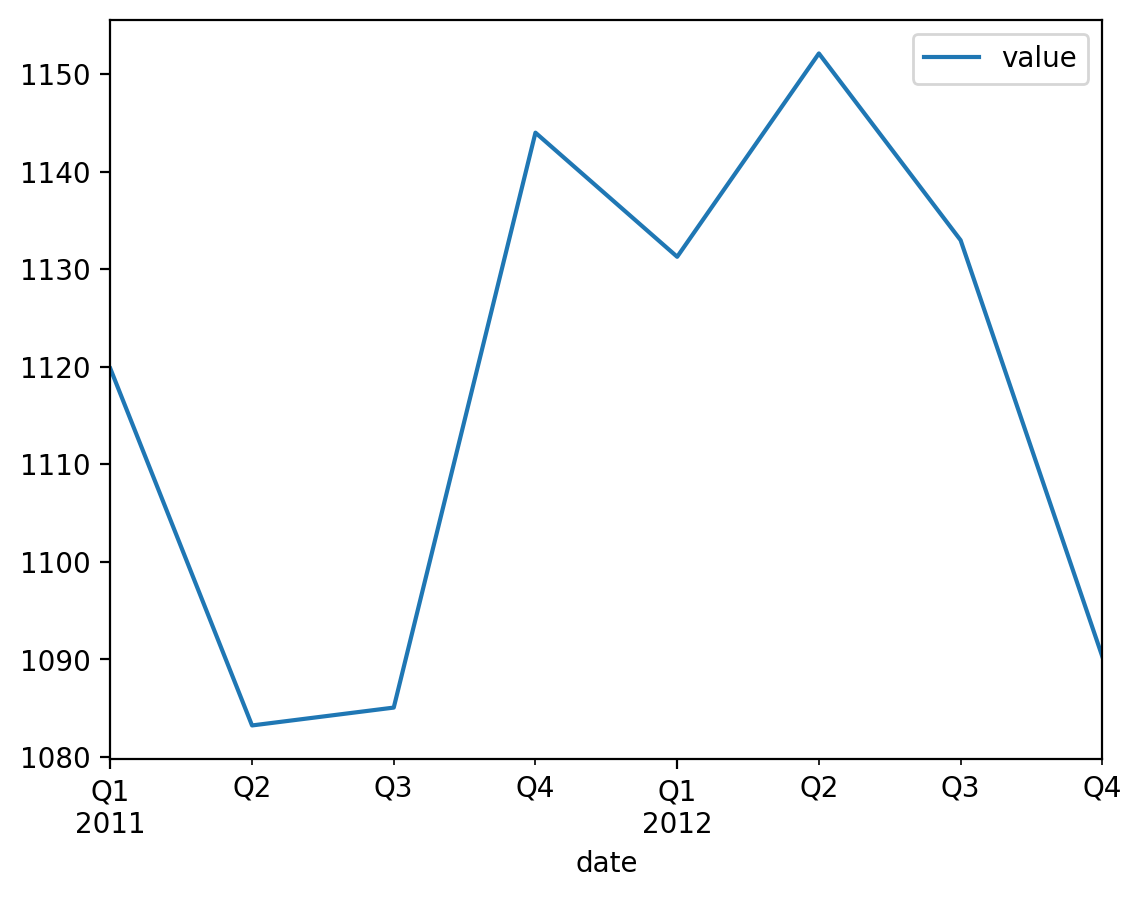

In [26]:
df.plot(x='date', y='value')

In [27]:
info

{'code': '731Y006',
 'name': '3.1.2.3. 원화의 대미달러, 원화의 대위안/대엔 환율',
 'itemcodes': ['0000003', '0000100', None, None],
 'itemnames': ['원/달러(종가)', '평균자료', None, None],
 'cycle': 'Q',
 'unit': '원',
 'wgt': None}

### Group1만 필요한 경우 예시

앞에서는 Group1과 Group2가 모두 필요한 경우에 대하여 살펴보았다. Group1만 필요한 경우 다음과 같이 한다.

In [28]:
from bok_da.data import ecosapi
ecos = ecosapi.EcosAPI(ecos_key)
# 통계표 검색
ecos.search_tbl('생산자물가지수.*총지수')

,Cat1,Cat2,Cat3,Cat4,Cat5,Cat6,ID
471,4. 물가,4.1. 생산자물가지수(2015=100),4.1.1. 생산자물가지수,4.1.1.4. 생산자물가지수-총지수(1910~1964),,,404Y017


In [29]:
# 통계항목 검색
stat_code = '404Y017'
ecos.download_items(stat_code, simplify = True)
ecos.items

,STAT_CODE,GRP_CODE,GRP_NAME,ITEM_CODE,ITEM_NAME,CYCLE,DATA_CNT,UNIT_NAME,START_TIME,END_TIME
0,404Y017,Group1,계정코드,*AA,총지수,A,55,2020=100,1910,1964
1,404Y017,Group1,계정코드,*AA,총지수,M,654,2020=100,191007,196412
2,404Y017,Group1,계정코드,*AA,총지수,Q,218,2020=100,1910Q3,1964Q4


In [30]:
# 데이터 다운로드
start_date = 1960 # or '1960'
end_date = 1964 # or '1964'

info,df = ecos.download_data(stat_code, ['*AA'], start_date, end_date, clean=True)
df

,time,year,value
0,1960,1960,2.2700
1,1961,1961,2.5732
2,1962,1962,2.8130
3,1963,1963,3.3915
4,1964,1964,4.5683


예제 코드를 정리하면 다음과 같다. 먼저 [ECOS 웹 인터페이스](https://ecos.bok.or.kr/#/SearchStat)에서 '전체다운로드' 버튼을 눌러 다운로드 받은 파일을 `ECOS-Tables.xlsx`로 저장한다. 그 후 다음을 진행한다.

```python
import pandas as pd
from bok_da.data import ecosapi

# 통계표 검색
ecos = ecosapi.EcosAPI(your_ecos_key)
ecos.search_tbl('대미달러.*환율') # 통계표코드(아래의 stat_code) 확인

# 통계항목 검색
stat_code = '731Y006'
n = ecos.download_items(stat_code, simplify = True)
ecos.search_item('(달러.*종가|평균자료)') # 통계항목, 시작시점, 종료시점 등 확인

# 데이터 다운로드
start_time = '2011Q1'
end_time = '2012Q4'
info,data = ecos.download_data(stat_code, ['0000003', '0000100'], start_time, end_time, clean=True)
```
통계표코드와 통계항목코드가 있으면 중간 단계는 필요 없고 마지막 줄만 실행하면 된다.

이 다음 단계는 `data` ([pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html))를 이용하는 것이다. 이 과정은 표준적이다.